In [1]:
import spacy
import numpy as np
import gzip
import json
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import tokenize_uk
from langdetect import detect
import pymorphy2
from collections import Counter

In [2]:
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [ ]:
# nlp_uk = spacy.load('/tmp/uk_vectors/news_cased_tokenized_word2vec') # no

In [ ]:
# nlp_uk = spacy.load('/tmp/uk_vectors/fiction_lowercased_tokenized_word2vec') # no

In [ ]:
# nlp_uk = spacy.load('/tmp/uk_vectors/news_lowercased_lemmatized_word2vec') # no

In [589]:
# nlp_uk = spacy.load('/tmp/uk_vectors/ubercorpus_lowercased_tokenized_word2vec') # n

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: UserWarning: [W019] Changing vectors name from uk_model.vectors to uk_model.vectors_538431, to avoid clash with previously loaded vectors. See Issue #3853.
  "__main__", mod_spec)


In [62]:
nlp_uk = spacy.load('/tmp/uk_vectors/ubercorpus_lowercased_lemmatized_word2vec') # used for grouping cats

In [ ]:
# nlp_uk = spacy.load('/tmp/uk_vectors/ubercorpus_cased_tokenized_word2vec') # no

In [ ]:
# nlp_uk = spacy.load('/tmp/uk_vectors/news_lowercased_tokenized_word2vec') # no

In [581]:
# nlp_uk = spacy.load('/tmp/uk_vectors/ubercorpus_cased_lemmatized') # no

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: UserWarning: [W019] Changing vectors name from uk_model.vectors to uk_model.vectors_331941, to avoid clash with previously loaded vectors. See Issue #3853.
  "__main__", mod_spec)


In [67]:
nlp_uk = spacy.load('/tmp/uk_vectors/ubercorpus_lowercased_tokenized') # for classification

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py:193: UserWarning: [W019] Changing vectors name from uk_model.vectors to uk_model.vectors_538429, to avoid clash with previously loaded vectors. See Issue #3853.
  "__main__", mod_spec)


In [4]:
def open_file(filename):
    with gzip.open(filename, 'rt', encoding='utf-8') as f:
        j = json.load(f)
        return j[0]['CallZText'], j[0]['CallZType']

In [131]:
PATH = '../../../../1551.gov.ua/raw/'


def read_files():
    data = []
    for d in os.listdir(PATH):
        files = os.listdir(PATH + '/' + d)
        for file in files:
            data.append(open_file(os.path.join(PATH + '/' + d + f'/{file}')))
    return data


def get_categories(data):
    return [y for _, y in data]


def get_claims(data, cats):
    return [x for x, y in data if y in cats]


def lowerize(text):
    words = tokenize_uk.tokenize_uk.tokenize_words(text)
    return ' '.join([x.lower() for x in words])


def vectorize_sent(v_unk, text, preprocessor):
    v = 0
    text_processed = preprocessor(text)

    doc = nlp_uk(text_processed)
    total_len = len(doc)
    for tok in doc:
        v += tok.vector
    return v_unk if type(v) == int else v


def vectorize_label(v_unk, text, preprocessor):
    text_processed = preprocessor(text)
    doc = nlp_uk(text_processed)
    v = doc.vector
    return doc.vector if doc.vector_norm else v_unk


def get_claim_label(claim_pair, cat_groups):
    label = 'Інше'
    claim, current_label = claim_pair
    for k, v in cat_groups.items():
        if current_label in v:
            label = k
    return label


def get_data(data, cat_groups):
    claims = []
    labels = []
    for x, y in data:
        label = get_claim_label((x, y), cat_groups)
        claims.append(x)
        labels.append(label)

    return claims, labels


def get_all_cat_nlps(cats):
    return [nlp_uk(x) for x in cats]


def normalize_cat(words):
    norm = []
    for w in words:
        m = morph.parse(w)[0]
        if m.tag.POS and m.tag.POS != 'PREP' and m.tag.POS != 'PRCL' and m.tag.POS != 'NUMR':
            norm.append(m.normal_form)

    return nlp_uk(' '.join(norm))


def is_similar_cats(cat1, cat2):

    def _is_water(w1, w2):
        waters = ['ХВП', 'ГВП']
        return any(x.upper() in waters for x in w1) and any(x.upper() in waters for x in w2)

    def _is_dism(w1, w2):
        dism = 'відсутність опалення'
        return set([x.lower() for x in w1]).intersection(dism) and \
            set([x.lower() for x in w2]).intersection(dism)

    def _is_lift(w1, w2):
        lift = 'ліфт'
        return lift in [x.lower() for x in w1] and lift in [x.lower() for x in w2]

    def _is_inst(w1, w2):
        keyword = 'встановлення'
        return keyword in [x.lower() for x in w1] and keyword in [x.lower() for x in w2]

    if not cat1 or not cat2:
        return False
    if not cat1.vector_norm or not cat2.vector_norm:
        min_len = min(len(cat1), len(cat2))
        if min_len < 3:
            return False

        skip_pos = ['CONJ']
        morph1 = [morph.parse(x.text)[0] for x in cat1]
        morph2 = [morph.parse(x.text)[0] for x in cat2]
        inter = set([x.normal_form for x in morph1 if x.tag.POS not in skip_pos]).\
            intersection(
                [x.normal_form for x in morph2 if x.tag.POS not in skip_pos])
        return len(inter)/min_len > 0.6

    w1 = tokenize_uk.tokenize_uk.tokenize_words(cat1)
    w2 = tokenize_uk.tokenize_uk.tokenize_words(cat2)

    if _is_water(w1, w2) or _is_dism(w1, w2) or _is_lift(w1, w2) or _is_inst(w1, w2):
        return True
    sim = normalize_cat(w1).similarity(normalize_cat(w2))
    return sim > 0.6


def get_common_group_name(docs):
    others = []
    fst_sent = docs[0].text
    words = fst_sent.split()
    if 'ХВП' in words or 'ГВП' in words:
        fst_sent = 'Проблеми з ХВП/ГВП'
    return fst_sent


def group_categories(cats, compare_fn):
    grouped = []
    cache = {}

    def _compare(a, b):
        if not cache.get((a, b)):
            is_sim = compare_fn(a, b)
            cache[(a, b)] = is_sim
            cache[(b, a)] = is_sim
        else:
            is_sim = cache[(a, b)]
        return is_sim

    def _is_most_comp(lst, item):
        similars = [x for x in lst if _compare(item, x)]
        if len(lst) < 3:
            return len(similars) == len(lst)
        if len(lst) == 3:
            return len(similars)/len(lst) > 0.6
        return len(similars)/len(lst) >= 0.4

    def _inner(cts):
        rst = []
        processed = []

        if len(cts) == 1:
            a, b = cts[0], None
        elif len(cts) > 2:
            a, b, *rest = cts
            rst = rest
        elif len(cts) == 2:
            a, b = cts

        if len(grouped):
            for gr in grouped:
                is_a = _is_most_comp(gr, a)
                is_b = _is_most_comp(gr, b)
                if is_a or is_b:
                    idx = grouped.index(gr)

                    if is_a:
                        grouped[idx].append(a)
                        processed.append(a)
                    if is_b:
                        grouped[idx].append(b)
                        processed.append(b)
        if a not in processed or b not in processed:
            if _compare(a, b):
                if a not in processed and b in processed:
                    grouped.append([a])
                elif a in processed and b not in processed:
                    grouped.append([b])
                else:
                    grouped.append([a, b])
            else:
                if a and a not in processed:
                    grouped.append([a])
                if b and b not in processed:
                    grouped.append([b])
        if rst:
            ll = len(rst)
            if ll % 10 == 0:
                print(ll)
            _inner(rst)
    _inner(cats)

    return grouped


def get_category_groups(cats, compare_fn):
    res = {}
    cats_grouped = group_categories(cats, compare_fn)
    for gr in cats_grouped:
        group_name = get_common_group_name(gr)
        res[group_name] = gr
    return res


def get_groups_text(cats_grouped):
    res = {}
    for k, v in cats_grouped.items():
        res[k] = [x.text for x in v]
    return res


def reduce_cats(cats):
    res = {'Інше': 0}
#     res = {}
    for x, y in cats:
        if y > 200:
            res[x] = y
        else:
            res['Інше'] += y
    return res


def get_all_claims(data):
    return [x for x, _ in data]


def get_all_claims_labels(data, categories_grouped):
    return [get_claim_label(x, categories_grouped) for x in data]


def filter_uk_claims(data):
    res = []
    for i, (x, y) in enumerate(data):
        try:
            lang = detect(x)
            if lang == 'uk':
                res.append((x, y))
        except:
            pass

#         if i % 1000 == 0:
#             print('>>', i)

    return res

In [65]:
def print_report(data, cats, v_unk, preprocessor):
    all_claims, all_labels = get_data(data, cats)
    X = [vectorize_sent(v_unk, x, preprocessor) for x in all_claims]
    y = all_labels

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.3, random_state=42, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)
    clf.fit(X_train, y_train)
    print(classification_report(y_test, clf.predict(X_test)))

In [7]:
data = read_files()

In [ ]:
uk_data = filter_uk_claims(data)

In [69]:
all_claim_categories_uk = sorted(Counter(get_categories(
    uk_data)).items(), key=lambda x: x[1], reverse=True)
all_claim_categories = sorted(Counter(get_categories(
    data)).items(), key=lambda x: x[1], reverse=True)

In [70]:
all_categories = sorted(set(reduce_cats(all_claim_categories)))
all_cat_nlps = get_all_cat_nlps(all_categories)

In [71]:
categories_grouped_nlp = get_category_groups(all_cat_nlps, is_similar_cats)
categories_grouped = get_groups_text(categories_grouped_nlp)

In [63]:
all_categories_uk = sorted(set(reduce_cats(all_claim_categories_uk)))
all_cat_nlps_uk = get_all_cat_nlps(all_categories_uk)

In [64]:
categories_grouped_nlp_uk = get_category_groups(
    all_cat_nlps_uk, is_similar_cats)
categories_grouped_uk = get_groups_text(categories_grouped_nlp_uk)

In [56]:
# with open('./cats_gr_uk.json', 'w') as f:
#     json.dump(categories_grouped, f, ensure_ascii=False)
# with open('./data_uk.json', 'w') as f:
#     json.dump(dict(uk_data), f, ensure_ascii=False)

In [48]:
v_unk = nlp_uk('unk')[0].vector

In [49]:
clf = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')

### 1. All data

In [72]:
print_report(data, categories_grouped, v_unk, lowerize)

                                                                                  precision    recall  f1-score   support

                                                                            Інше       0.40      0.63      0.49      8221
                                                                     Інші Подяки       0.50      0.17      0.25       154
                                              Інші технічні недоліки стану ліфту       0.25      0.37      0.30       464
                Аварійний, травмонебезпечний стан утримання об’єктів благоустрою       0.37      0.42      0.39      1362
                                  Будівництво/дооблаштування дитячого майданчику       0.33      0.60      0.43       349
                                Видалення аварійних, пошкоджених хворобами дерев       0.42      0.32      0.36       165
                                                      Вилов безпритульних тварин       0.52      0.35      0.42        72
                       

### 2. Only UK data

In [68]:
print_report(uk_data, categories_grouped_uk, v_unk, lowerize)

                                                                                  precision    recall  f1-score   support

                                                                            Інше       0.59      0.77      0.67      8156
                                                                     Інші Подяки       0.55      0.12      0.20       101
                                              Інші технічні недоліки стану ліфту       0.29      0.39      0.33       204
                Аварійний, травмонебезпечний стан утримання об’єктів благоустрою       0.50      0.48      0.49       699
                                  Будівництво/дооблаштування дитячого майданчику       0.47      0.67      0.55       191
                                Видалення аварійних, пошкоджених хворобами дерев       0.55      0.39      0.46        92
                                            Вирізування (кронування) гілля дерев       0.49      0.32      0.39        69
                       

In [813]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

RS = 20150101
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [884]:
def visualize(data, cats, v_unk, preprocessor):
    claims_labeled = [(x, get_claim_label((x, y), cats)) for x, y in data]
    all_labels = np.array([y for x, y in claims_labeled])

    labs_set = [all_labels[all_labels == x] for x in set(all_labels)]
    claim_vectors_labeled = np.array(
        [(vectorize_sent(v_unk, x, preprocessor), y) for x, y in claims_labeled])
    claim_vectors_grouped = [
        claim_vectors_labeled[all_labels == x] for x in set(all_labels)]

    claim_vectors_normalized = [x[0]
                                for subl in claim_vectors_grouped for x in subl]

    X = np.vstack(claim_vectors_normalized)
    y = np.hstack(labs_set)

    digits_proj = TSNE(random_state=RS).fit_transform(X)

    scatter(digits_proj, y)


def scatter(x, labels):
    labels_set = list(set(labels))
    colors = np.array([labels_set.index(x) for x in labels])
    palette = np.array(sns.husl_palette(len(labels_set)))

    f = plt.figure(figsize=(10, 10))
    ax = plt.subplot(aspect='auto')
    sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-50, 50)
    plt.ylim(-50, 50)
    ax.axis('off')
    ax.axis('tight')

    legends = []
    leg_labels_processed = []

    for i in range(len(colors)):
        if not labels[i] in leg_labels_processed:
            rgb = palette[colors.astype(np.int)[i]]
            legend = mpatches.Patch(color=rgb.tolist(), label=labels[i])
            legends.append(legend)
            leg_labels_processed.append(labels[i])
    lgd = plt.legend(handles=legends, bbox_to_anchor=[1, 1], fontsize=12)
    plt.savefig('./viz.png', dpi=120,
                bbox_extra_artists=(lgd,), bbox_inches='tight')

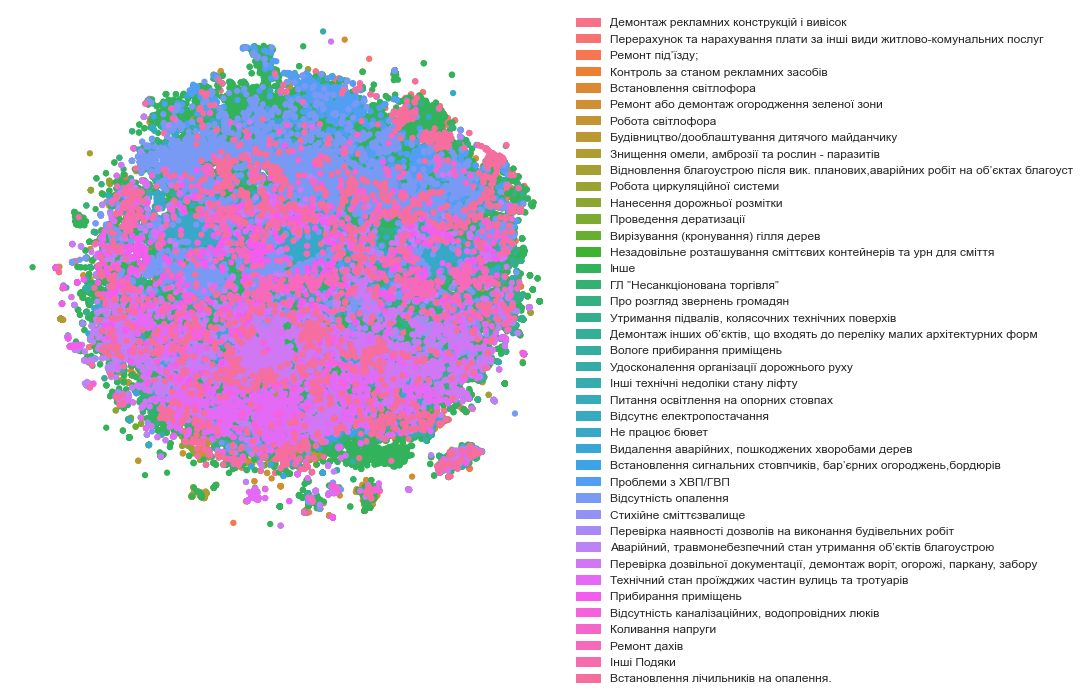

In [888]:
visualize(uk_data, categories_grouped_uk, v_unk, lowerize)